In [0]:
from torchvision import datasets, transforms
import torch 

batch_size = 64

transform = transforms.ToTensor()

traindata = datasets.MNIST(root='MNIST', download='True', train='True', transform=transform)
trainloader = torch.utils.data.DataLoader(traindata, batch_size=batch_size)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 21270768.40it/s]                            


Extracting MNIST/MNIST/raw/train-images-idx3-ubyte.gz to MNIST/MNIST/raw


32768it [00:00, 327476.53it/s]
0it [00:00, ?it/s]

Extracting MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/MNIST/raw


1654784it [00:00, 5318364.02it/s]                           
8192it [00:00, 128920.89it/s]


Extracting MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/MNIST/raw
Extracting MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/MNIST/raw
Processing...
Done!


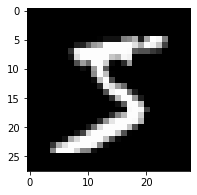

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt 
import numpy as np

dataiter = iter(traindata)
images, labels = next(dataiter)

images = images.numpy()

img = np.squeeze(images[0])

fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

In [0]:
import torch.nn as nn 
import torch.nn.functional as F

class Discriminator(nn.Module):

  def __init__(self, input_size, hidden_dim, output_size):

    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim*4)
    self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
    self.fc4 = nn.Linear(hidden_dim, output_size)
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):

    x = x.view(-1, 784)
    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    x = self.fc4(x)
  
    return x

class Generator(nn.Module):

  def __init__(self, input_size, hidden_dim, output_size):

    super().__init__()
    self.fc1 = nn.Linear(input_size, hidden_dim)
    self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
    self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
    self.fc4 = nn.Linear(hidden_dim*4, output_size)
    self.dropout = nn.Dropout(0.3)
  
  def forward(self, x):

    x = F.leaky_relu(self.fc1(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc2(x), 0.2)
    x = self.dropout(x)
    x = F.leaky_relu(self.fc3(x), 0.2)
    x = self.dropout(x)
    x = torch.tanh(self.fc4(x))
  
    return x

input_size = 784
output_size = 1 
d_hidden_size = 32

z_size = 100 
g_output_size = 784 
g_hidden_size = 32 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator(input_size, d_hidden_size, output_size)
G = Generator(z_size, g_hidden_size, g_output_size)

D, G = D.to(device), G.to(device)

print(D)
print()
print(G)
print(device)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)
cuda:0


In [0]:
def real_loss(D_out, smooth=False):

  batch_size = D_out.size(0)

  if smooth:
    labels = torch.ones(batch_size) * 0.9
  else:
    labels = torch.ones(batch_size)

  criterion = nn.BCEWithLogitsLoss()
  labels = labels.to(device)
  loss = criterion(D_out.squeeze(), labels)
  
  return loss

def fake_loss(D_out):

  batch_size = D_out.size(0)
  labels = torch.zeros(batch_size)
  criterion = nn.BCEWithLogitsLoss()
  labels = labels.to(device)
  loss = criterion(D_out.squeeze(), labels)

  return loss

In [0]:
import torch.optim as optim 

d_optimizer = optim.Adam(D.parameters(), lr=0.002)
g_optimizer = optim.Adam(G.parameters(), lr=0.002)


In [0]:
import pickle as pkl 
import time 

start_time = time.time()
num_epochs = 100

samples = []
losses = []

print_every = 400 

sample_size = 16 
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
print(fixed_z.shape)
fixed_z = torch.from_numpy(fixed_z).float()
fixed_z = fixed_z.to(device)

D.train()
G.train()

for epoch in range(num_epochs):

  for batch_i, (real_img, _) in enumerate(trainloader):
    
    batch_size = real_img.size(0)
    real_img = real_img*2 - 1
    real_img = real_img.to(device)
    # ============================
    # TRAIN THE DISCRIMINATOR
    # ============================

    d_optimizer.zero_grad()
    
    # 1. Train with real images

    # Compute the discriminator losses on real images    
    D_real = D(real_img).to(device)
    d_real_loss = real_loss(D_real, smooth=True)
    
    # 2. Train with fake images
    
    # Generate fake images
    img = np.random.uniform(-1, 1, size=(batch_size, z_size))
    img = torch.from_numpy(img).float()
    img = img.to(device)
    fake_img = G(img).to(device)

    # Compute the discriminator losses on fake images    
    D_fake = D(fake_img).to(device)
    d_fake_loss = fake_loss(D_fake).to(device)

    d_loss = d_real_loss + d_fake_loss 
    d_loss.backward()
    d_optimizer.step()

    # ==========================
    # TRAIN THE GENERATOR 
    # ==========================

    g_optimizer.zero_grad()

    # 1. Train with fake images and flipped labels

    # Generate fake images 
    img = np.random.uniform(-1, 1, size=(batch_size, z_size))
    img = torch.from_numpy(img).float()
    img = img.to(device)
    fake_img = G(img).to(device)

    # Compute the discriminator losses on fake images 
    # using flipped labels ! 
    D_fake = D(fake_img).to(device)
    g_loss = real_loss(D_fake).to(device) #use real loss to flip labels 

    # perform backprop 
    g_loss.backward()
    g_optimizer.step()

    if batch_i % print_every == 0:
      print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
          epoch+1, num_epochs, d_loss.item(), g_loss.item()))
      
    ## AFTER EACH EPOCH ##
    # append discriminator loss and generator loss 
  losses.append((d_loss.item(), g_loss.item()))
  G.eval()
    
  samples_z = G(fixed_z).to(device)
  samples.append(samples_z)
  # print(samples)
  G.train()


with open('train_samples.pkl', 'wb') as f:
  pkl.dump(samples, f)
    
finished_time = time.time()

print('Total time to train data : %.2f s' %(finished_time - start_time))



(16, 100)
Epoch [    1/  100] | d_loss: 1.3598 | g_loss: 0.7454
Epoch [    1/  100] | d_loss: 1.1770 | g_loss: 2.6956
Epoch [    1/  100] | d_loss: 1.1337 | g_loss: 1.0626
Epoch [    2/  100] | d_loss: 1.3137 | g_loss: 0.6887
Epoch [    2/  100] | d_loss: 1.3374 | g_loss: 0.7324
Epoch [    2/  100] | d_loss: 1.3348 | g_loss: 0.8875
Epoch [    3/  100] | d_loss: 0.9557 | g_loss: 1.5369
Epoch [    3/  100] | d_loss: 0.9950 | g_loss: 1.7575
Epoch [    3/  100] | d_loss: 0.9380 | g_loss: 2.5180
Epoch [    4/  100] | d_loss: 1.3234 | g_loss: 0.6849
Epoch [    4/  100] | d_loss: 1.3165 | g_loss: 1.0036
Epoch [    4/  100] | d_loss: 1.2320 | g_loss: 1.3351
Epoch [    5/  100] | d_loss: 0.9381 | g_loss: 3.9775
Epoch [    5/  100] | d_loss: 0.9903 | g_loss: 1.6420
Epoch [    5/  100] | d_loss: 0.9436 | g_loss: 1.7494
Epoch [    6/  100] | d_loss: 1.1174 | g_loss: 3.3446
Epoch [    6/  100] | d_loss: 0.9961 | g_loss: 2.4547
Epoch [    6/  100] | d_loss: 1.0739 | g_loss: 2.3393
Epoch [    7/  100

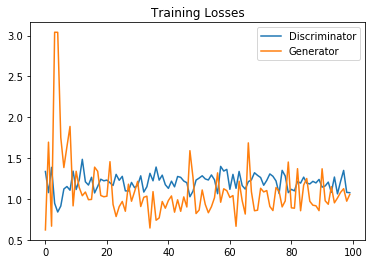

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator')
plt.plot(losses.T[1], label='Generator')
plt.title("Training Losses")
plt.legend()

In [0]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().to("cpu")
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

In [0]:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)


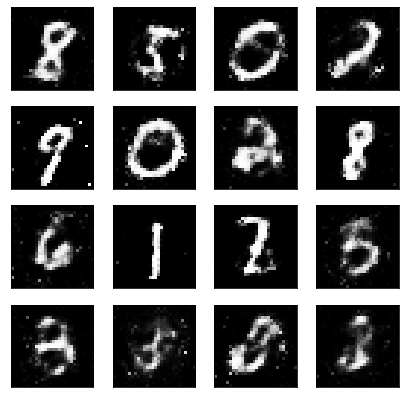

In [0]:
view_samples(-3, samples)

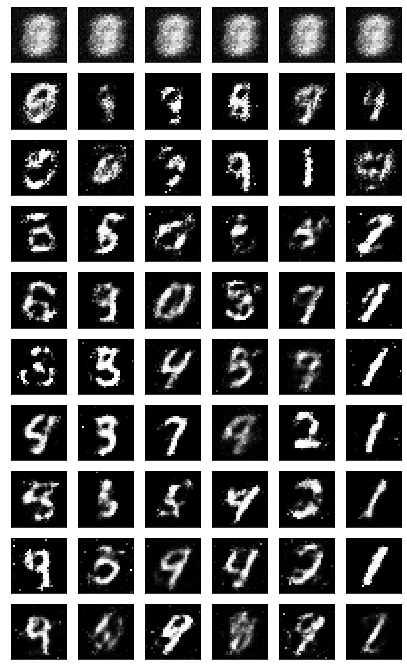

In [0]:
rows = 10 # split epochs into 10, so 100/10 = every 10 epochs
cols = 6
fig, axes = plt.subplots(figsize=(7,12), nrows=rows, ncols=cols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/rows)], axes):
    for img, ax in zip(sample[::int(len(sample)/cols)], ax_row):
        img = img.detach().to("cpu")
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)